In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# Завантаження даних
df = pd.read_csv('insurance.csv')
original_df = df
# Огляд датасету
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [3]:
df.shape

(1338, 7)

In [4]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [5]:
# Описова статистика
print(df.describe())

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


In [6]:
# Перевірка на пропущені значення
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [7]:
# Створення нової колонки age_group
age_bins = [0, 30, 60, np.inf]
names = ['Youth', 'Adult', 'Senior']
df['age_group'] = pd.cut(df['age'], age_bins, labels=names)

# Створення нової колонки bmi_group
weight_bins = [0, 18.5, 24.9, 29.9, np.inf]
names = ['Underweight', 'Healthy weight', 'Overweight', 'Obese']
df['bmi_group'] = pd.cut(df['bmi'], weight_bins, labels=names)

print(df.head())

   age     sex     bmi  children smoker     region      charges age_group  \
0   19  female  27.900         0    yes  southwest  16884.92400     Youth   
1   18    male  33.770         1     no  southeast   1725.55230     Youth   
2   28    male  33.000         3     no  southeast   4449.46200     Youth   
3   33    male  22.705         0     no  northwest  21984.47061     Adult   
4   32    male  28.880         0     no  northwest   3866.85520     Adult   

        bmi_group  
0      Overweight  
1           Obese  
2           Obese  
3  Healthy weight  
4      Overweight  


array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'bmi'}>],
       [<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'charges'}>]], dtype=object)

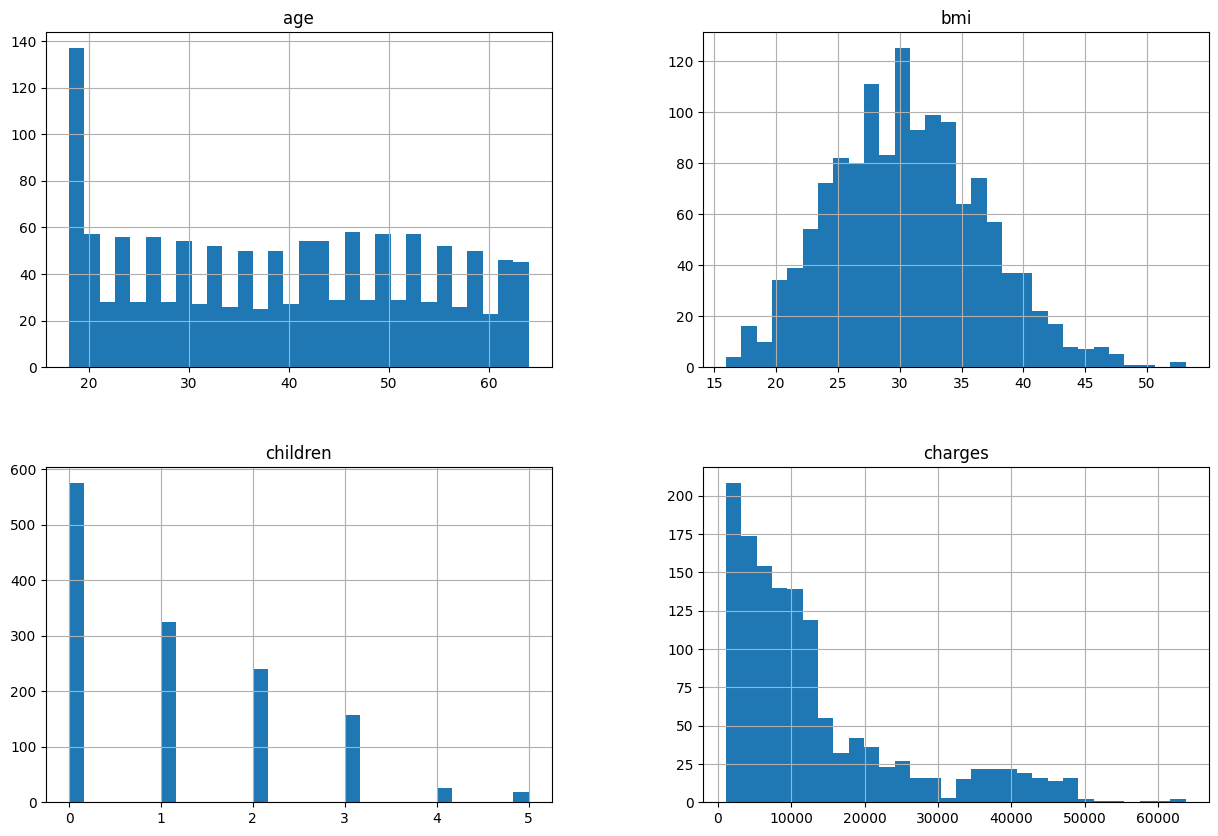

In [8]:
# Гістограми для числових змінних
num_vars = ['age', 'bmi', 'children', 'charges']
df[num_vars].hist(bins=30, figsize=(15, 10))

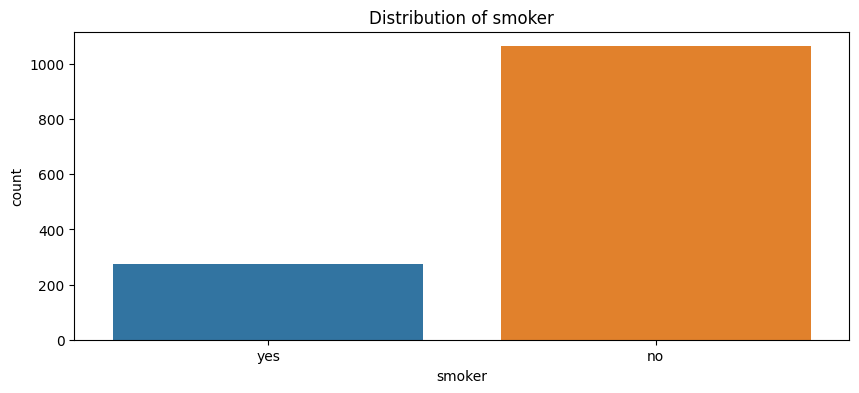

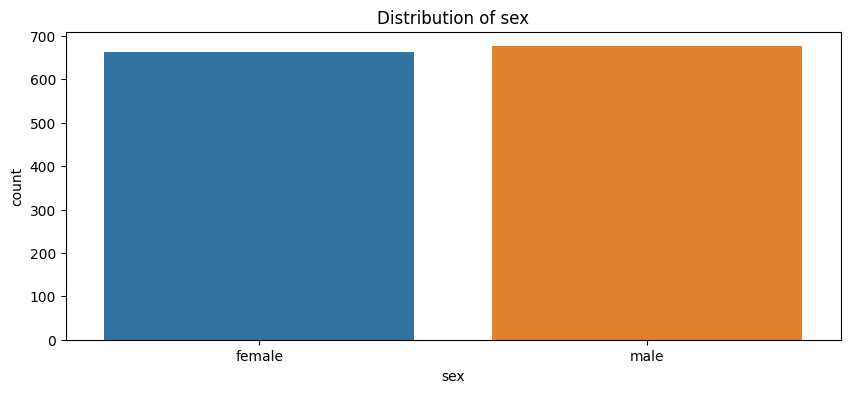

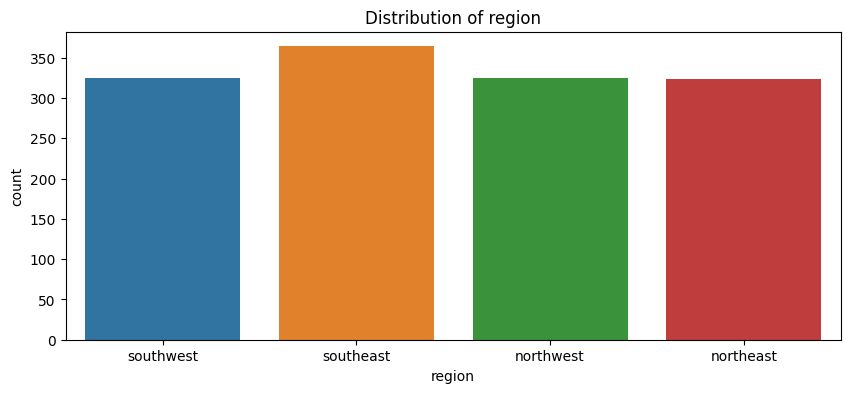

In [9]:
cat_vars = ['smoker', 'sex', 'region']
for var in cat_vars:
    plt.figure(figsize=(10,4))
    sns.countplot(x=var, data=df)
    plt.title(f'Distribution of {var}')
    plt.show()

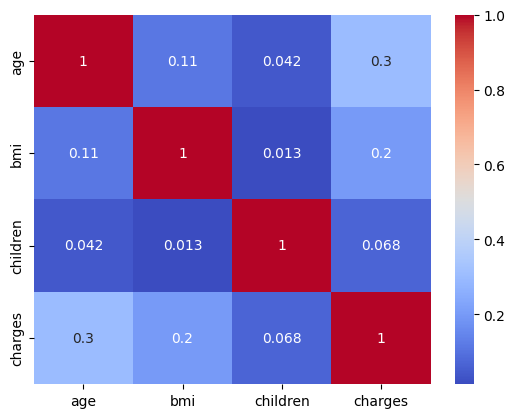

In [10]:
# Кореляція між числовими змінними
correlation = df[num_vars].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')

plt.show()

In [11]:
df.drop(['children'], axis=1)
one_hot_encoded = pd.get_dummies(df, columns=['age_group', 'bmi_group', 'sex', 'region', 'smoker'], drop_first=False)

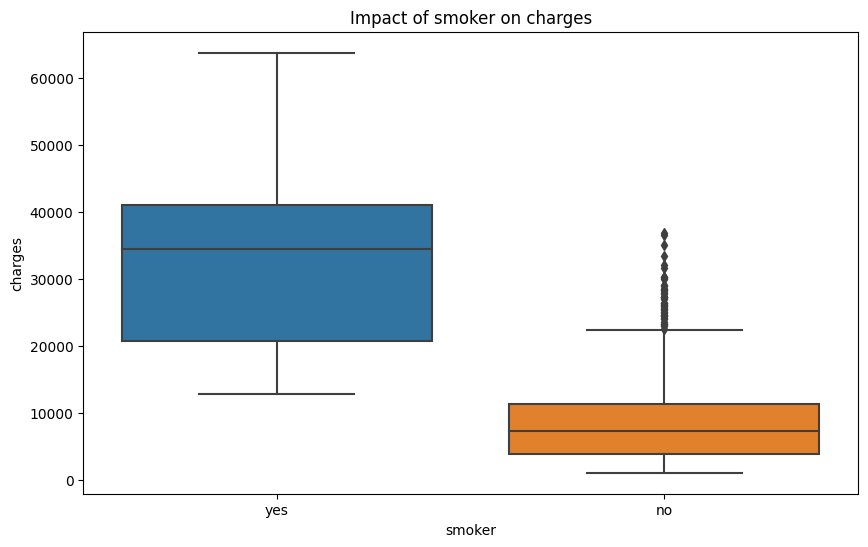

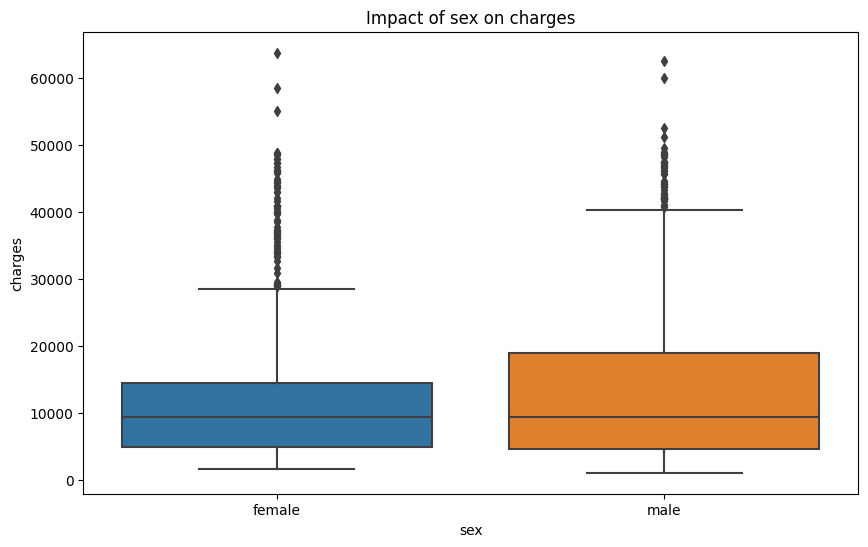

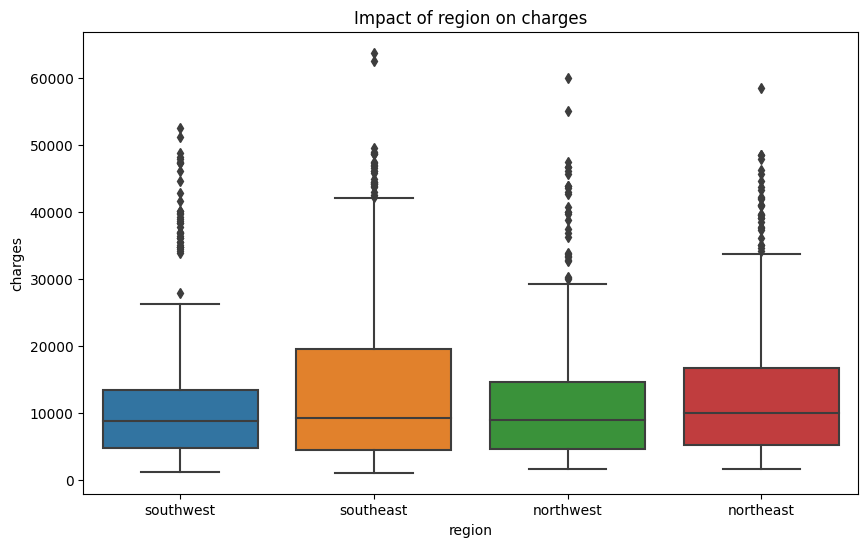

In [12]:
for var in cat_vars:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=var, y='charges', data=df)
    plt.title(f'Impact of {var} on charges')
    plt.show()

In [24]:
# Розбиваємо charges на категорії
charges_bins = [0, df['charges'].quantile(0.33), df['charges'].quantile(0.66), df['charges'].max()]
names = ['Low', 'Medium', 'High']
df['charges_cat'] = pd.cut(df['charges'], charges_bins, labels=names)

# Кодуємо категоріальні змінні
le = LabelEncoder()
for col in ['sex', 'smoker', 'region', 'age_group', 'bmi_group', 'charges_cat']:
    df[col] = le.fit_transform(df[col])

# Розділяємо дані на тренувальний та тестовий набори
X = df.drop(['charges', 'charges_cat', 'age', 'bmi'], axis=1)
y = df['charges_cat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Створюємо список моделей
models = [
    ('Logistic Regression', LogisticRegression()),
    ('Naive Bayes', GaussianNB()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Support Vector Machine', svm.SVC()),
    ('Random Forest', RandomForestClassifier())
]

# Зберігаємо результати
results = []

# Тренуємо та оцінюємо кожну модель
for name, model in models:
    model = svm.SVC(probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')  # для мультикласової класифікації
    f1 = f1_score(y_test, y_pred, average='weighted')  # для мультикласової класифікації
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')  # для мультикласової класифікації

    results.append([name, accuracy, recall, f1, roc_auc])


Logistic Regression - Accuracy: 0.8208955223880597
Logistic Regression - Recall: 0.8208955223880597
Logistic Regression - F1 Score: 0.8212893864013268
Logistic Regression - ROC AUC Score: 0.8872089554579402


Naive Bayes - Accuracy: 0.8208955223880597
Naive Bayes - Recall: 0.8208955223880597
Naive Bayes - F1 Score: 0.8212893864013268
Naive Bayes - ROC AUC Score: 0.8876242022813331


Decision Tree - Accuracy: 0.8208955223880597
Decision Tree - Recall: 0.8208955223880597
Decision Tree - F1 Score: 0.8212893864013268
Decision Tree - ROC AUC Score: 0.8882618418019271


Support Vector Machine - Accuracy: 0.8208955223880597
Support Vector Machine - Recall: 0.8208955223880597
Support Vector Machine - F1 Score: 0.8212893864013268
Support Vector Machine - ROC AUC Score: 0.8879331396761591


Random Forest - Accuracy: 0.8208955223880597
Random Forest - Recall: 0.8208955223880597
Random Forest - F1 Score: 0.8212893864013268
Random Forest - ROC AUC Score: 0.88782829175456




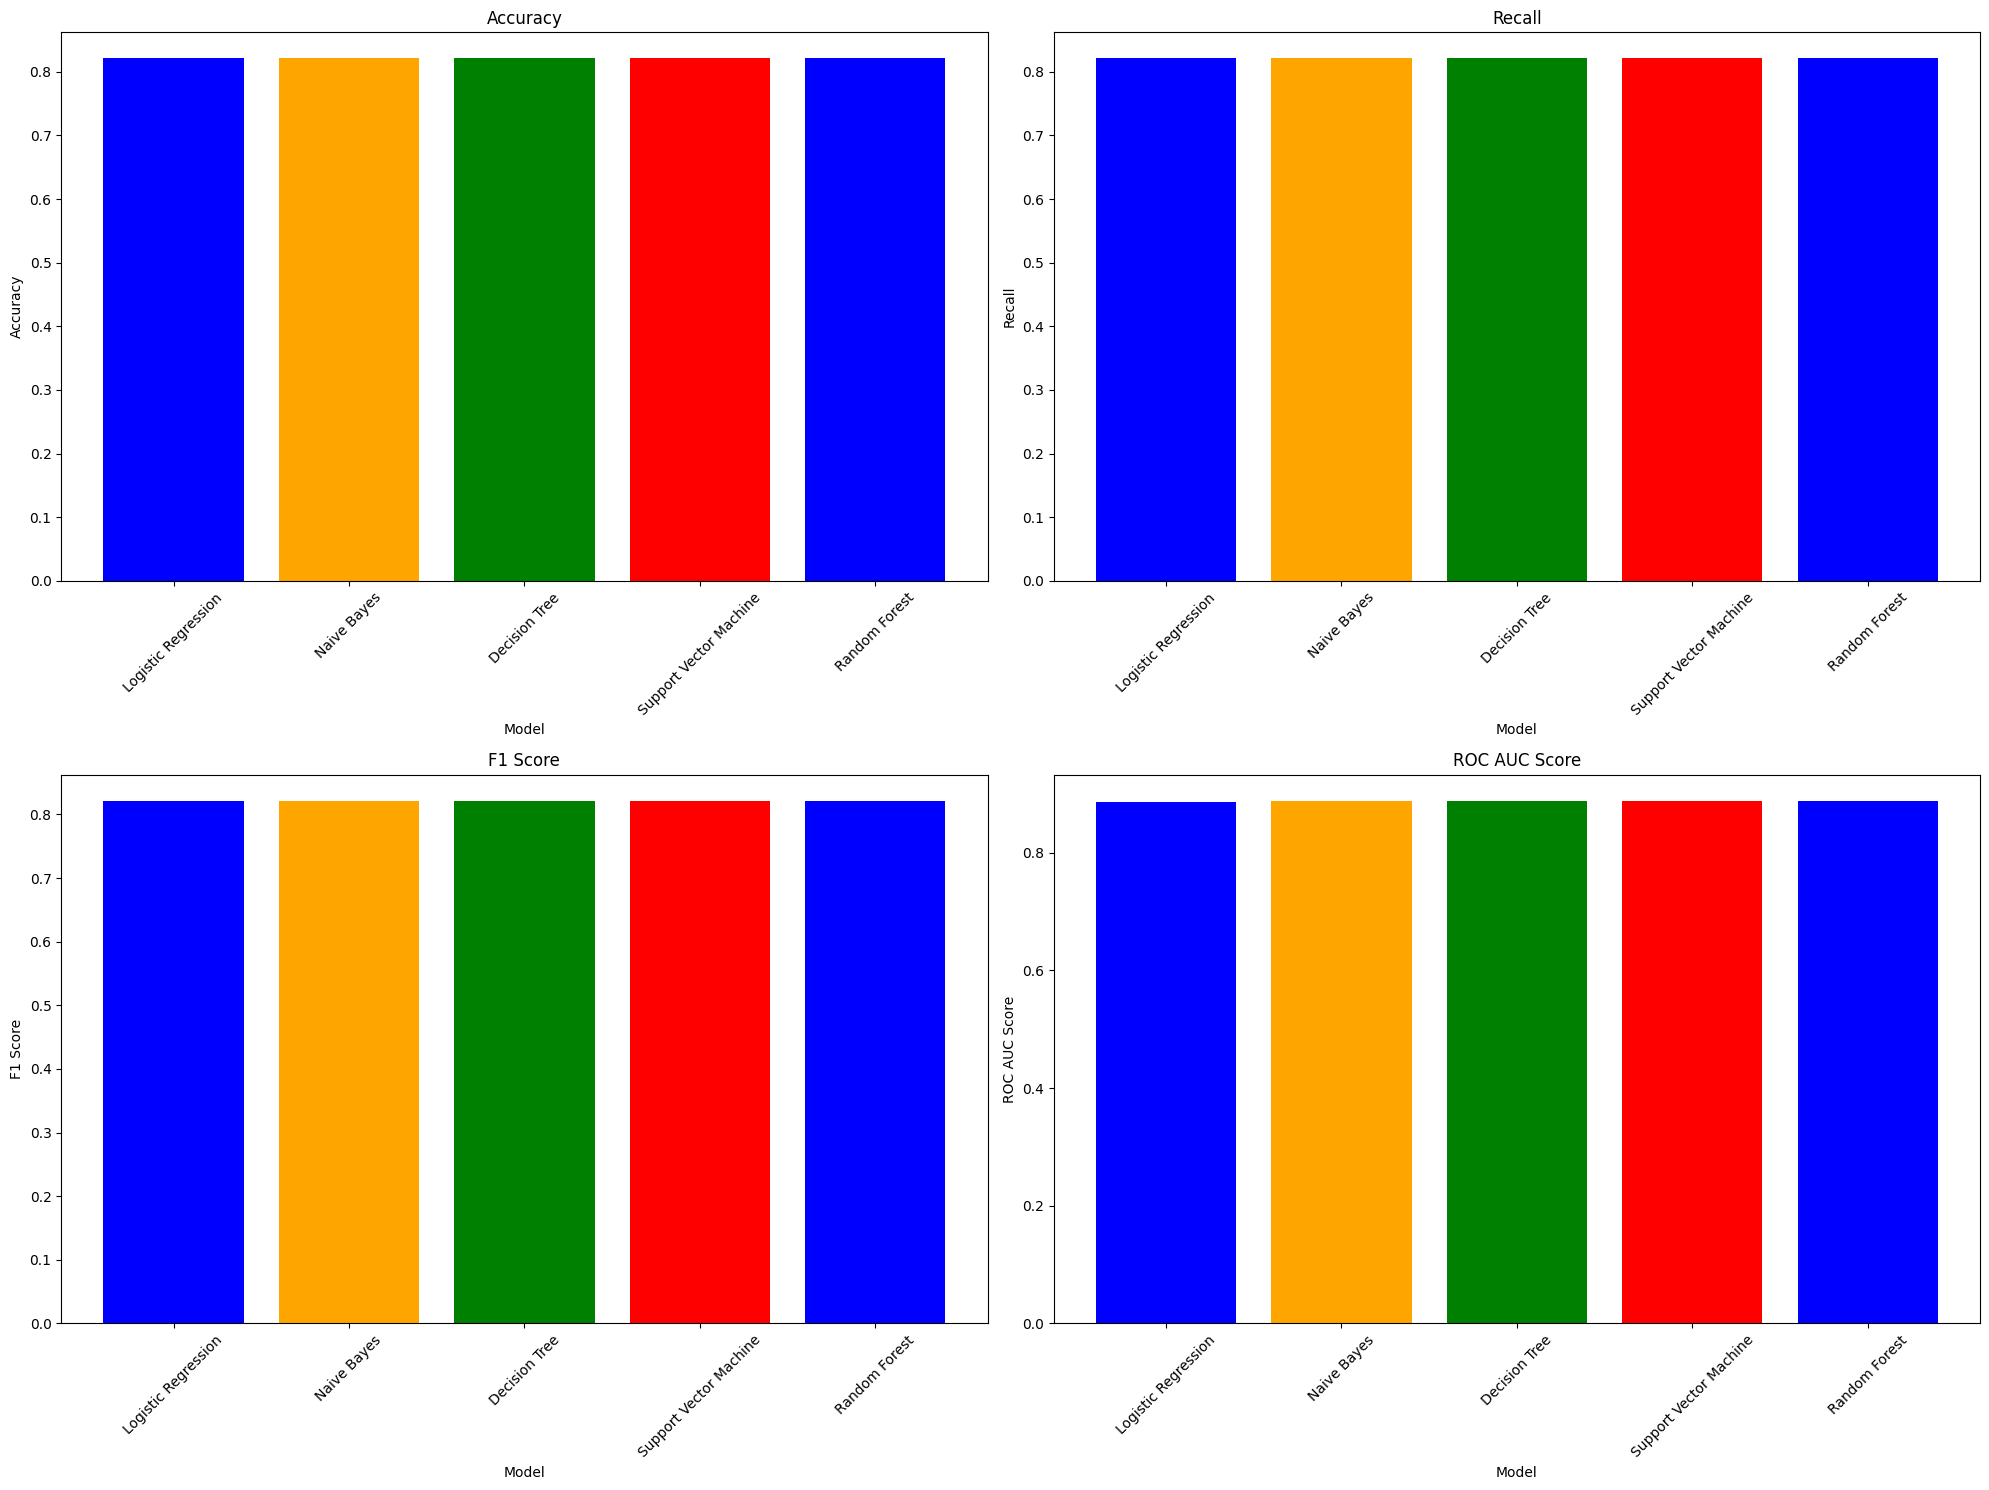

In [26]:
# Метрики та моделі
metrics = ['Model', 'Accuracy', 'Recall', 'F1 Score', 'ROC AUC Score']

# Визначення розміру графіку
plt.figure(figsize=(20,15))

model_results_df = pd.DataFrame(results, columns=metrics)

for index, row in model_results_df.iterrows():
    print(f"{row['Model']} - Accuracy: {row['Accuracy']}")
    print(f"{row['Model']} - Recall: {row['Recall']}")
    print(f"{row['Model']} - F1 Score: {row['F1 Score']}")
    print(f"{row['Model']} - ROC AUC Score: {row['ROC AUC Score']}")
    print("\n")

# Окремий графік для кожної метрики
for i, metric in enumerate(metrics[1:]):  # Пропустіть першу колонку (Model)
    plt.subplot(2, 2, i+1)
    plt.bar(model_results_df['Model'], model_results_df[metric], color=['blue', 'orange', 'green', 'red'])
    plt.title(metric)
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [27]:
# Визначаємо параметри, які хочемо перевірити
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Створюємо базову модель
rf = RandomForestClassifier()

# Ініціюємо пошук по сітці
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

# Проводимо пошук по сітці
grid_search.fit(X_train, y_train)

# Виводимо найкращі параметри
best_params = grid_search.best_params_
print(best_params)


Fitting 3 folds for each of 288 candidates, totalling 864 fits
{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


c:\users\serhii\appdata\local\programs\python\python39\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [28]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=5)

# Тренуємо модель
rf.fit(X_train, y_train)

# Робимо прогнози
y_pred = rf.predict(X_test)

# Перетворюємо мітки в бінарний формат для розрахунку roc_auc
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_bin = label_binarize(y_pred, classes=[0, 1, 2])

# Обчислюємо метрики
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test_bin, y_pred_bin, average='macro', multi_class='ovr')

# Виводимо метрики
print('Accuracy: ', accuracy)
print('Recall: ', recall)
print('F1 Score: ', f1)
print('ROC AUC: ', roc_auc)

Accuracy:  0.8208955223880597
Recall:  0.8113784461152882
F1 Score:  0.8161111111111112
ROC AUC:  0.8603279469769344


     Feature  Importance
2     smoker    0.492076
4  age_group    0.432421
1   children    0.037352
3     region    0.017567
5  bmi_group    0.014938
0        sex    0.005645


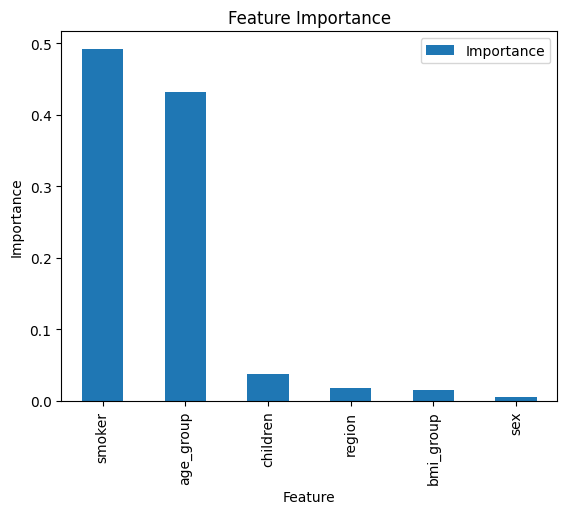

In [30]:
# Отримуємо важливість ознак
importances = rf.feature_importances_

# Отримуємо імена ознак
features = original_df.drop(['charges', 'charges_cat', 'age', 'bmi'], axis=1).columns

# Створюємо DataFrame для відображення важливості ознак
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

# Сортуємо DataFrame за важливістю ознак в порядку спадання
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Виводимо важливість ознак
print(importance_df)

# Створюємо графік важливості ознак
importance_df.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
